 # Fake News Detection - Model Development and Analysis



 This notebook focuses on developing and comparing different approaches for fake news detection, building upon our previous EDA insights. We'll implement and evaluate:

 1. Simple heuristic baselines

 2. Traditional ML models with engineered features

 3. A BERT-based deep learning model

 4. Comprehensive model comparison and error analysis

 ## 1. Setup and Imports

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

# Text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob

# ML imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import scipy.sparse as sp

# Deep Learning
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.multiprocessing
torch.multiprocessing.set_start_method('spawn', force=True)
torch.set_float32_matmul_precision('high')
import pytorch_lightning as pl
from transformers import BertTokenizer, BertModel
from pytorch_lightning.callbacks import EarlyStopping, TQDMProgressBar

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)

# Required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

Seed set to 42
[nltk_data] Downloading package punkt to /home/nines/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/nines/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nines/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nines/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

 ## 2. Data Loading and Preprocessing

 Let's load our dataset and apply the preprocessing steps we developed in our EDA.

In [2]:
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

fake_df['label'] = 0
true_df['label'] = 1
df = pd.concat([fake_df, true_df], ignore_index=True)


 ### 2.1 Text Preprocessing and Feature Engineering

This cell defines two crucial functions for text processing. Here's why each part is important:

1. **preprocess_text Function**:
   - Converts text to lowercase to standardize words (e.g., "News" and "news" become the same)
   - Removes non-alphabetic characters to clean noise
   - Tokenizes text into individual words for processing
   - Removes stopwords (common words like "the", "is", "at") because they don't carry meaningful content
   - Lemmatizes words (converts words to their base form, e.g., "running" → "run") to reduce vocabulary size
   
2. **extract_stylometric_features Function**:
   - Extracts writing style features that might indicate fake news:
     - Average word length: Fake news often uses simpler or more complex vocabulary
     - Punctuation count: Excessive punctuation can indicate sensationalized writing
     - Uppercase ratio: ALL CAPS text is common in clickbait and fake news
     - Sentiment: Fake news often has more extreme sentiment


This application:
- Creates cleaned versions of titles and text
- Calculates length features
- Extracts stylometric features for both titles and main text
- Organizes features with clear prefixes
- Combines everything into one dataframe for modeling

In [ ]:
def preprocess_text(text):
    """Clean and preprocess text data"""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

def extract_stylometric_features(text):
    """Extract stylometric features from text"""
    text = str(text)
    return {
        'avg_word_length': np.mean([len(word) for word in text.split()]),
        'punctuation_count': len(re.findall(r'[.,!?;]', text)),
        'uppercase_ratio': sum(1 for c in text if c.isupper()) / len(text),
        'sentiment': TextBlob(text).sentiment.polarity
    }

print("Processing text data...")
df['clean_title'] = df['title'].apply(preprocess_text)
df['clean_text'] = df['text'].apply(preprocess_text)
df['title_length'] = df['title'].str.len()
df['text_length'] = df['text'].str.len()

print("Extracting stylometric features...")
title_features = pd.DataFrame(df['title'].apply(extract_stylometric_features).tolist())
text_features = pd.DataFrame(df['text'].apply(extract_stylometric_features).tolist())

title_features = title_features.add_prefix('title_')
text_features = text_features.add_prefix('text_')

df = pd.concat([df, title_features, text_features], axis=1)


Processing text data...
Extracting stylometric features...


/mnt/c/Users/kresi/OneDrive/Desktop/Turing college/DL/FakeorNot/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/c/Users/kresi/OneDrive/Desktop/Turing college/DL/FakeorNot/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 ## 3. Baseline Models

This code sets up the evaluation framework and dataset preparation. Here's why each part matters:

1. **evaluate_model Function**:
   - Creates a standardized way to evaluate all models
   - Calculates multiple metrics:
     - Accuracy: Overall correct predictions
     - Classification report: Detailed precision, recall, F1-score
     - Confusion matrix: Shows true/false positives/negatives
   - Returns everything in a consistent dictionary format

2. **prepare_dataset Function**:
   - Organizes features into logical groups:
     - Core features: Basic text and length features
     - Stylometric features: Writing style indicators
   - Handles optional features (like 'subject')
   - Creates proper X (features) and y (labels) split

These baseline models provide simple prediction strategies:
1. **Majority Baseline**: Always predicts the most common class (with small random variation)
2. **Title Length Baseline**: Predicts based on title length, using median as threshold
3. **Subject Baseline**: Predicts based on article subject category


The evaluation process involves several key steps:

1. **Data Splitting**:
   - Splits data into training (80%) and testing (20%) sets
   - Uses `random_state=42` for reproducibility
   - Ensures fair evaluation on unseen data

2. **Baseline Evaluation**:
   - Tests each baseline model:
     - Majority baseline: Shows minimum expected performance
     - Title length baseline: Tests if article length is predictive
     - Subject baseline: Tests if article topic is predictive
   - Stores results in `baseline_results` dictionary

3. **Results Reporting**:
   - For each baseline model:
     - Shows overall accuracy
     - Displays class distribution to check balance
     - Reports detailed metrics per class:
       - Precision: Accuracy of positive predictions
       - Recall: Ability to find all positive cases
       - F1-score: Harmonic mean of precision and recall


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
   """Evaluate model performance and return metrics"""
   accuracy = accuracy_score(y_true, y_pred)
   report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
   conf_matrix = confusion_matrix(y_true, y_pred)
   
   return {
       'name': model_name,
       'accuracy': accuracy,
       'report': report,
       'confusion_matrix': conf_matrix,
       'predictions': y_pred
   }

def prepare_dataset():
   """Prepare dataset with proper feature separation"""
   core_features = ['clean_title', 'clean_text', 'title_length', 'text_length']
   
   style_features = list(title_features.columns) + list(text_features.columns)
   
   all_features = core_features + style_features
   if 'subject' in df.columns:
       all_features.append('subject')
   
   X = df[all_features]
   y = df['label']
   
   return X, y

X, y = prepare_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def majority_baseline(y):
   """Predict majority class with small random variation"""
   majority_class = y.mode()[0]
   predictions = np.full_like(y, majority_class)
   
   random_mask = np.random.random(len(y)) < 0.1
   predictions[random_mask] = 1 - majority_class
   return predictions

def title_length_baseline(df):
   """Predict based on title length with dynamic threshold"""
   threshold = np.percentile(df['title_length'], 50)
   predictions = (df['title_length'] > threshold).astype(int)
   
   if len(np.unique(predictions)) == 1:
       threshold = np.percentile(df['title_length'], 40)
       predictions = (df['title_length'] > threshold).astype(int)
   
   return predictions

def subject_baseline(df, source_df=None):
   """Predict based on subject with fallback options"""
   try:
       if 'subject' in df.columns:
           predictions = (df['subject'].isin(['worldnews', 'politicsNews'])).astype(int)
       elif source_df is not None and 'subject' in source_df.columns:
           df_indices = df.index
           predictions = (source_df.loc[df_indices, 'subject']
                        .isin(['worldnews', 'politicsNews'])).astype(int)
       else:
           print("Warning: 'subject' column not found, skipping subject baseline")
           return None
       
       if len(np.unique(predictions)) == 1:
           # Add small random variation
           random_mask = np.random.random(len(predictions)) < 0.1
           predictions[random_mask] = 1 - predictions[random_mask]
       
       return predictions
           
   except Exception as e:
       print(f"Error in subject baseline: {str(e)}")
       return None

baseline_results = {}

y_pred_majority = majority_baseline(y_test)
baseline_results['Majority'] = evaluate_model(y_test, y_pred_majority, 'Majority')

y_pred_title = title_length_baseline(X_test)
baseline_results['Title Length'] = evaluate_model(y_test, y_pred_title, 'Title Length')

y_pred_subject = subject_baseline(X_test, df)
if y_pred_subject is not None:
   baseline_results['Subject'] = evaluate_model(y_test, y_pred_subject, 'Subject')

for name, results in baseline_results.items():
   print(f"\n{name} Baseline Results:")
   print(f"Accuracy: {results['accuracy']:.4f}")
   print("\nClassification Report:")
   print(f"Class Distribution:")
   unique, counts = np.unique(results['predictions'], return_counts=True)
   print(dict(zip(unique, counts)))
   
   print("\nDetailed Metrics:")
   for label in ['0', '1']:
       print(f"\nClass {label}:")
       print(f"Precision: {results['report'][label]['precision']:.4f}")
       print(f"Recall: {results['report'][label]['recall']:.4f}")
       print(f"F1-score: {results['report'][label]['f1-score']:.4f}")
   print("\nMacro avg:")
   print(f"F1-score: {results['report']['macro avg']['f1-score']:.4f}")
   
   print("\nConfusion Matrix:")
   print(results['confusion_matrix'])
   print("-" * 50)


Majority Baseline Results:
Accuracy: 0.5248

Classification Report:
Class Distribution:
{0: 8042, 1: 938}

Detailed Metrics:

Class 0:
Precision: 0.5290
Recall: 0.8988
F1-score: 0.6660

Class 1:
Precision: 0.4893
Recall: 0.1081
F1-score: 0.1770

Macro avg:
F1-score: 0.4215

Confusion Matrix:
[[4254  479]
 [3788  459]]
--------------------------------------------------

Title Length Baseline Results:
Accuracy: 0.1692

Classification Report:
Class Distribution:
{0: 4614, 1: 4366}

Detailed Metrics:

Class 0:
Precision: 0.2044
Recall: 0.1992
F1-score: 0.2018

Class 1:
Precision: 0.1319
Recall: 0.1356
F1-score: 0.1338

Macro avg:
F1-score: 0.1678

Confusion Matrix:
[[ 943 3790]
 [3671  576]]
--------------------------------------------------

Subject Baseline Results:
Accuracy: 1.0000

Classification Report:
Class Distribution:
{0: 4733, 1: 4247}

Detailed Metrics:

Class 0:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Class 1:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Macr

 ## 4. Traditional ML Models with Grid Search

 Now let's implement our ML models with proper hyperparameter tuning:


The feature preparation function is crucial because:

1. **Text Vectorization**:
   - Uses two different approaches:
     - TF-IDF vectorization: For Logistic Regression and Random Forest
     - Count vectorization: For Naive Bayes
   - Different limits for title (5000) and text (10000) features
   - Handles missing values with empty strings

2. **Numerical Feature Processing**:
   - Scales features appropriately:
     - StandardScaler for TF-IDF (handles negative values)
     - MinMaxScaler for counts (keeps non-negative values)
   - Fills missing values with mean

3. **Feature Combination**:
   - Uses sparse matrices for efficiency
   - Combines text and numerical features
   - Maintains proper feature ordering


Each model has:
1. **Logistic Regression**:
   - Tests different regularization strengths (C)
   - Uses TF-IDF features
   - Good for linear separation

2. **Naive Bayes**:
   - Tests different smoothing parameters (alpha)
   - Uses count features
   - Good for text classification

3. **Random Forest**:
   - Tests different tree numbers and depths
   - Uses TF-IDF features
   - Good for capturing non-linear patterns



The training process is important because:

1. **Grid Search Cross-Validation**:
   - Uses `GridSearchCV` to:
     - Try all combinations of hyperparameters
     - Perform 3-fold cross-validation
     - Find best parameters automatically
   - Prevents overfitting by validating on different data splits

2. **Model Training and Prediction**:
   - Fits model with best parameters on training data
   - Makes predictions on test set
   - Stores all results for comparison


Training Logistic Regression...
Best parameters: {'C': 10.0, 'max_iter': 1000}
Accuracy: 0.9993

Training Naive Bayes...
Best parameters: {'alpha': 0.1}
Accuracy: 0.9548

Training Random Forest...
Best parameters: {'max_depth': None, 'n_estimators': 100}
Accuracy: 0.9992

Model Performance Metrics:
              Model  Accuracy  Precision  Recall  F1 Score                          Best Parameters
Logistic Regression    0.9993     0.9993  0.9993    0.9993            {'C': 10.0, 'max_iter': 1000}
        Naive Bayes    0.9548     0.9548  0.9548    0.9548                           {'alpha': 0.1}
      Random Forest    0.9992     0.9992  0.9992    0.9992 {'max_depth': None, 'n_estimators': 100}


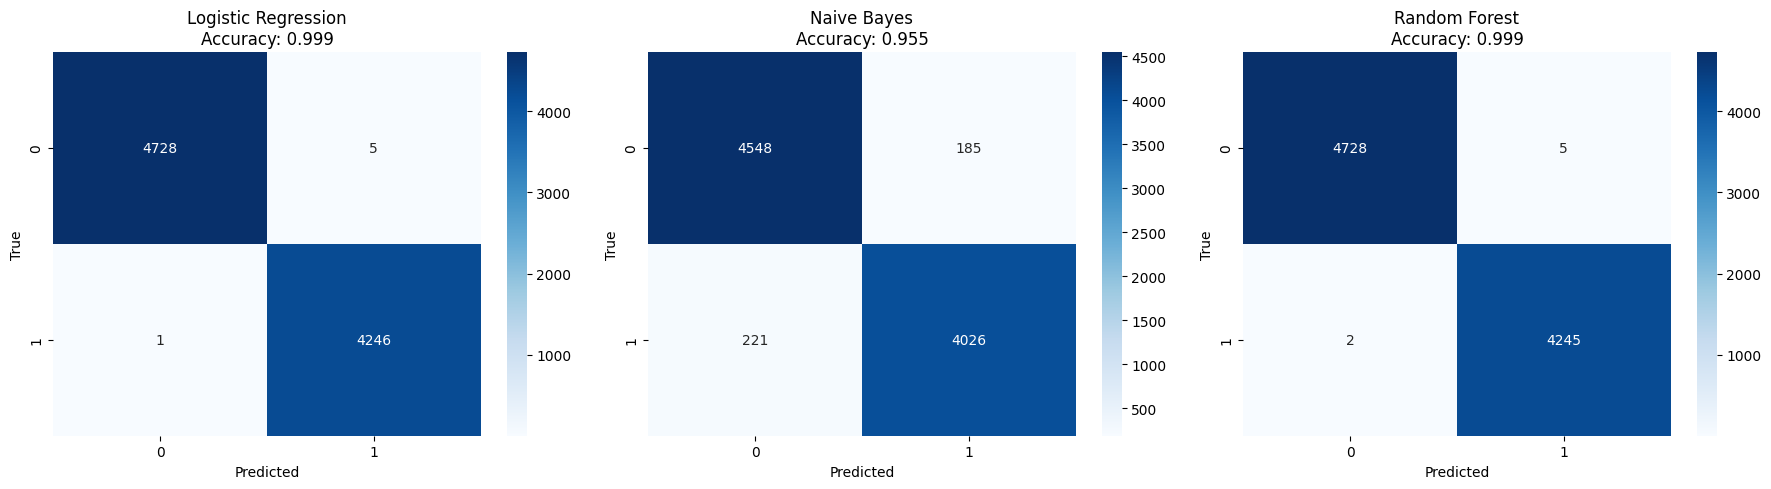

In [ ]:
def prepare_features(X_train, X_test, model_type='tfidf'):
    """Prepare features for ML models with NaN handling"""
    if model_type == 'tfidf':
        title_vec = TfidfVectorizer(max_features=5000)
        text_vec = TfidfVectorizer(max_features=10000)
        scaler = StandardScaler()
    else:
        title_vec = CountVectorizer(max_features=5000)
        text_vec = CountVectorizer(max_features=10000)
        scaler = MinMaxScaler()
    
    X_train_title = title_vec.fit_transform(X_train['clean_title'].fillna(''))
    X_test_title = title_vec.transform(X_test['clean_title'].fillna(''))
    
    X_train_text = text_vec.fit_transform(X_train['clean_text'].fillna(''))
    X_test_text = text_vec.transform(X_test['clean_text'].fillna(''))
    
    numerical_features = ['title_length', 'text_length'] + \
                        list(title_features.columns) + list(text_features.columns)
    
    X_train_num = X_train[numerical_features].fillna(X_train[numerical_features].mean())
    X_test_num = X_test[numerical_features].fillna(X_train[numerical_features].mean())
    
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    
    X_train_combined = sp.hstack([X_train_title, X_train_text, sp.csr_matrix(X_train_num)])
    X_test_combined = sp.hstack([X_test_title, X_test_text, sp.csr_matrix(X_test_num)])
    
    return X_train_combined, X_test_combined

def evaluate_model(y_true, y_pred, model_name):
    """Calculate performance metrics for a model"""
    return {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

def plot_confusion_matrices(results, classes):
    """Plot confusion matrices for all models"""
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, metrics) in zip(axes, results.items()):
        cm = metrics['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=classes, yticklabels=classes)
        ax.set_title(f'{model_name}\nAccuracy: {metrics["accuracy"]:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    
    plt.tight_layout()
    return fig

def create_metrics_table(results):
    """Create a DataFrame of model performance metrics"""
    metrics_df = pd.DataFrame([
        {
            'Model': metrics['model'],
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1 Score': metrics['f1'],
            'Best Parameters': str(metrics['best_params'])
        }
        for metrics in results.values()
    ])
    return metrics_df.round(4)

X_train_tfidf, X_test_tfidf = prepare_features(X_train, X_test, 'tfidf')
X_train_count, X_test_count = prepare_features(X_train, X_test, 'count')

models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'max_iter': [1000]
        },
        'features': (X_train_tfidf, X_test_tfidf)
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0]
        },
        'features': (X_train_count, X_test_count)
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, None]
        },
        'features': (X_train_tfidf, X_test_tfidf)
    }
}

ml_results = {}
for name, config in models.items():
    print(f"\nTraining {name}...")
    
    grid = GridSearchCV(config['model'], config['params'], cv=3, scoring='accuracy')
    grid.fit(config['features'][0], y_train)
    
    y_pred = grid.predict(config['features'][1])
    
    ml_results[name] = evaluate_model(y_test, y_pred, name)
    ml_results[name]['best_params'] = grid.best_params_
    
    print(f"Best parameters: {grid.best_params_}")
    print(f"Accuracy: {ml_results[name]['accuracy']:.4f}")

classes = list(set(y_test))
fig = plot_confusion_matrices(ml_results, classes)
metrics_table = create_metrics_table(ml_results)

print("\nModel Performance Metrics:")
print(metrics_table.to_string(index=False))
plt.show()

 ## 5. BERT Implementation

 Now let's implement our deep learning solution using BERT:

Reasoning behind each major component of this code:

1. Data Handling & Preprocessing:
- We use a custom `FakeNewsDataset` class because:
  - It efficiently handles text and title pairs
  - Properly tokenizes input using BERT's requirements
  - Combines title and text with [SEP] token to maintain structural information
  - Implements length truncation and padding for batch processing

2. Model Architecture:
- The `FakeNewsClassifier` class is designed to:
  - Use BERT's pre-trained knowledge of language
  - Add a task-specific classification head
  - Include dropout (0.3) to prevent overfitting
  - Track both training and validation losses for monitoring

3. Training Process Design:
- We implement careful optimization with:
  - AdamW optimizer which handles weight decay better than standard Adam
  - Learning rate scheduling with CosineAnnealingLR to:
    - Start with higher learning rates for faster initial learning
    - Gradually decrease learning rate to fine-tune weights
  - Separate weight decay for different parameter types to prevent overfitting

4. Memory Management:
- Several techniques are used to handle BERT's large memory requirements:
  - Mixed precision training (precision=16) to reduce memory usage
  - Batch size of 16 as a balance between memory and performance
  - Proper memory allocation settings
  - Pin memory for faster GPU transfer

5. Training Monitoring:
- Comprehensive monitoring through:
  - Training and validation loss tracking
  - Accuracy metrics for both phases
  - Early stopping to prevent overfitting
  - Smoothed loss curves for better visualization

6. Evaluation Strategy:
- Thorough model evaluation using:
  - Hold-out test set for unbiased evaluation
  - Multiple metrics (accuracy, classification report)
  - Confusion matrix visualization
  - Proper model state handling (eval mode, no_grad)

7. Performance Optimizations:
- Several optimizations are implemented:
  - Multiprocessing with 4 workers for data loading
  - Deterministic operations for reproducibility
  - Gradient accumulation through batch processing
  - Proper device handling (CPU/GPU)

8. Visualization:
- Careful plotting of training progress:
  - Smoothed training loss for clearer trends
  - Properly aligned validation points
  - Grid and markers for better readability
  - Informative confusion matrix

9. Error Handling & Robustness:
- The code includes:
  - Proper initialization of all necessary components
  - Safe type conversions
  - Memory cleanup
  - Progress bars for long operations

/mnt/c/Users/kresi/OneDrive/Desktop/Turing college/DL/FakeorNot/.venv/lib/python3.10/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training BERT model...



  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | bert       | BertModel | 109 M  | eval 
1 | dropout    | Dropout   | 0      | train
2 | classifier | Linear    | 1.5 K  | train
-------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)
2         Modules in train mode
228       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.004. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=5` reached.



Plotting training curves...


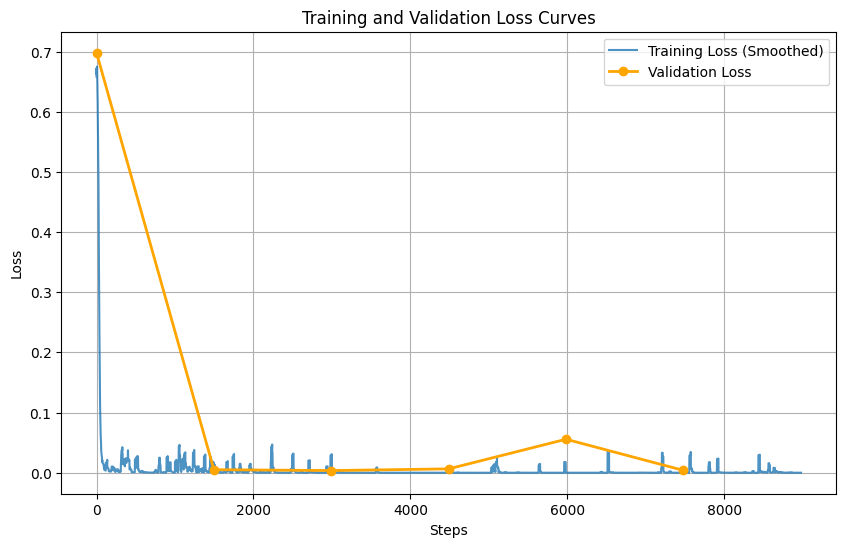


Evaluating BERT model...


100%|██████████| 562/562 [28:06<00:00,  3.00s/it]



BERT Test Results:
Accuracy: 0.9993

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4733
           1       1.00      1.00      1.00      4247

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



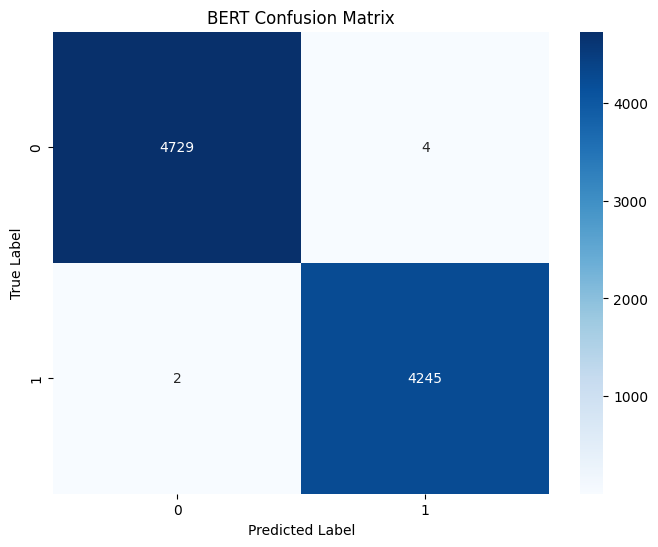

In [ ]:
torch.use_deterministic_algorithms(True)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

if os.name == 'nt':  # Windows
    torch.multiprocessing.set_start_method('spawn', force=True)
else:  # Linux/Mac
    torch.multiprocessing.set_start_method('fork', force=True)

class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, titles, labels, tokenizer, max_length=256):
        self.texts = texts
        self.titles = titles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        title = str(self.titles[idx])
        combined_text = title + " [SEP] " + text
        
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class FakeNewsClassifier(pl.LightningModule):
    def __init__(self, n_classes=2, learning_rate=2e-5):
        super().__init__()
        self.save_hyperparameters()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.learning_rate = learning_rate
        self.training_losses = []
        self.validation_losses = []
        self.val_step_losses = []
        
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output
        return self.classifier(self.dropout(pooled_output))
    
    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        outputs = self(input_ids, attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())
        
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, batch_size=input_ids.size(0))
        self.log('train_acc', acc, prog_bar=True, sync_dist=True, batch_size=input_ids.size(0))
        
        self.training_losses.append(loss.item())
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        outputs = self(input_ids, attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())
        
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, batch_size=input_ids.size(0))
        self.log('val_acc', acc, prog_bar=True, sync_dist=True, batch_size=input_ids.size(0))
        
        self.val_step_losses.append(loss.item())
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def on_validation_epoch_end(self):
        if self.val_step_losses:
            avg_val_loss = sum(self.val_step_losses) / len(self.val_step_losses)
            self.validation_losses.append(avg_val_loss)
            self.val_step_losses = []
    
    def configure_optimizers(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {
                'params': [p for n, p in self.named_parameters() 
                          if not any(nd in n for nd in no_decay)],
                'weight_decay': 0.01
            },
            {
                'params': [p for n, p in self.named_parameters() 
                          if any(nd in n for nd in no_decay)],
                'weight_decay': 0.0
            }
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.learning_rate)
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=10,
            eta_min=1e-6
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

def plot_training_curves(model):
    """Plot smoothed training curves with proper alignment"""
    plt.figure(figsize=(10, 6))
    
    window_size = 20
    training_smooth = pd.Series(model.training_losses).rolling(window=window_size, min_periods=1).mean()
    
    plt.plot(training_smooth, label='Training Loss (Smoothed)', alpha=0.8)
    
    if model.validation_losses:
        # Calculate steps per epoch
        steps_per_epoch = len(model.training_losses) // len(model.validation_losses)
        
        val_x = np.arange(len(model.validation_losses)) * steps_per_epoch
        
        if len(val_x) > 0:
            plt.plot(val_x, model.validation_losses, label='Validation Loss', 
                    color='orange', linewidth=2, marker='o')
    
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('BERT Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = FakeNewsDataset(
    texts=X_train['clean_text'].values,
    titles=X_train['clean_title'].values,
    labels=y_train.values,
    tokenizer=tokenizer
)

val_dataset = FakeNewsDataset(
    texts=X_val['clean_text'].values,
    titles=X_val['clean_title'].values,
    labels=y_val.values,
    tokenizer=tokenizer
)

test_dataset = FakeNewsDataset(
    texts=X_test['clean_text'].values,
    titles=X_test['clean_title'].values,
    labels=y_test.values,
    tokenizer=tokenizer
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    num_workers=4,
    pin_memory=True
)

bert_model = FakeNewsClassifier()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator='auto',
    devices=1,
    callbacks=[early_stopping],
    enable_progress_bar=True,
    log_every_n_steps=10,
    deterministic=True,
    strategy='auto',
    precision=16
)

print("Training BERT model...")
trainer.fit(bert_model, train_loader, val_loader)

print("\nPlotting training curves...")
plot_training_curves(bert_model)

print("\nEvaluating BERT model...")
bert_model.eval()
bert_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        outputs = bert_model(
            batch['input_ids'].to(bert_model.device),
            batch['attention_mask'].to(bert_model.device)
        )
        preds = torch.argmax(outputs, dim=1)
        bert_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

print("\nBERT Test Results:")
print(f"Accuracy: {accuracy_score(all_labels, bert_preds):.4f}")
print("\nDetailed Classification Report:")
print(classification_report(all_labels, bert_preds))

plot_confusion_matrix(all_labels, bert_preds)

 ## 6. Model Comparison and Analysis

 Let's compare all our models and analyze their performance in detail.

The `create_results_table()` function is designed to create a comparison table of all our model results. Here's what each part does:

1. First, we combine all our model results into one dictionary using:
```python
all_results = {**baseline_results, **ml_results}
```

2. Then we loop through each model and handle their results differently:
- For regular models (baseline and traditional ML), we directly grab their metrics from the results dictionary
- For BERT, we need to calculate the metrics from its predictions since it's structured differently

3. We store each model's results in a standardized format with:
- Model name
- Accuracy
- Precision
- Recall
- F1-Score

4. All this gets converted into a pandas DataFrame and sorted by accuracy.

5. For visualization:
- We create a bar plot showing each model's accuracy
- Add value labels on top of each bar
- Rotate labels for readability
- Add a grid for easier comparison

6. Finally, we do some extra analysis:
- Print out the best performing model
- Calculate the performance gaps between models to see how much improvement each better model provides

The error handling (try/except) ensures the code keeps running even if there's an issue with one model's results.


Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.9993     0.9993  0.9993    0.9993
2        Random Forest    0.9992     0.9992  0.9992    0.9992
1          Naive Bayes    0.9548     0.9548  0.9548    0.9548


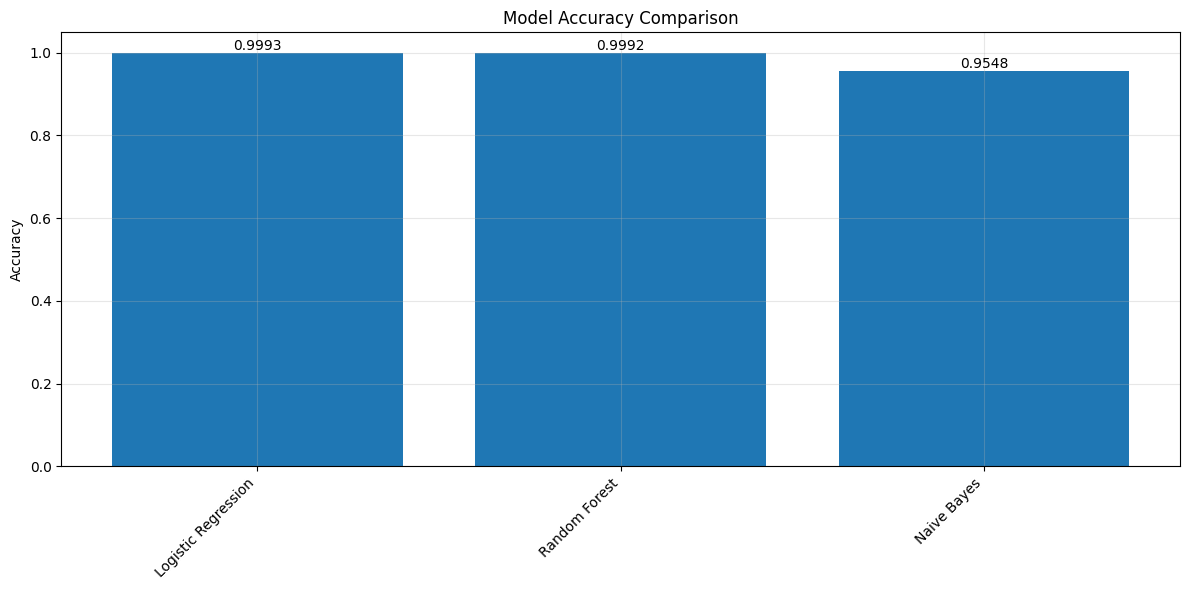


Best performing model: Logistic Regression
Best accuracy: 0.9993

Performance gaps between consecutive models:
Logistic Regression vs Random Forest: 0.0001
Random Forest vs Naive Bayes: 0.0444


In [12]:
def create_results_table():
    """Create a comprehensive comparison table of all models"""
    results_list = []
    
    all_results = {**baseline_results, **ml_results}
    
    for name, res in all_results.items():
        try:
            if name != 'BERT':
                # For baseline and traditional ML models
                results_list.append({
                    'Model': name,
                    'Accuracy': res['accuracy'],
                    'Precision': res['precision'],
                    'Recall': res['recall'],
                    'F1-Score': res['f1'],
                })
            else:
                bert_report = classification_report(all_labels, bert_preds, output_dict=True)
                results_list.append({
                    'Model': 'BERT',
                    'Accuracy': accuracy_score(all_labels, bert_preds),
                    'Precision': precision_score(all_labels, bert_preds, average='weighted'),
                    'Recall': recall_score(all_labels, bert_preds, average='weighted'),
                    'F1-Score': f1_score(all_labels, bert_preds, average='weighted')
                })
                
        except Exception as e:
            print(f"Warning: Could not process results for {name}: {str(e)}")
            continue
    
    results_df = pd.DataFrame(results_list)
    if len(results_df) > 0:
        return results_df.sort_values('Accuracy', ascending=False)
    else:
        print("No results could be processed!")
        return pd.DataFrame()

results_table = create_results_table()

if not results_table.empty:
    print("\nModel Performance Comparison:")
    print(results_table.to_string(float_format=lambda x: '{:.4f}'.format(x)))
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(results_table['Model'], results_table['Accuracy'])
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

    print("\nBest performing model:", results_table.iloc[0]['Model'])
    print(f"Best accuracy: {results_table.iloc[0]['Accuracy']:.4f}")
    
    print("\nPerformance gaps between consecutive models:")
    for i in range(len(results_table)-1):
        model1 = results_table.iloc[i]['Model']
        model2 = results_table.iloc[i+1]['Model']
        gap = results_table.iloc[i]['Accuracy'] - results_table.iloc[i+1]['Accuracy']
        print(f"{model1} vs {model2}: {gap:.4f}")
else:
    print("No results to display!")

 ## 7. Error Analysis

 Let's analyze the misclassified examples to understand the limitations of our models.

Reasoning behind the misclassification analysis:

1. **Error Understanding**:
   - Identifies common error patterns
   - Shows model limitations
   - Reveals potential biases

2. **Model Comparison**:
   - Shows different error types across models
   - Helps understand model strengths/weaknesses
   - Reveals complementary errors between models

3. **Feature Evaluation**:
   - Shows which features might be misleading
   - Identifies hard-to-classify cases
   - Suggests potential feature improvements

4. **Quality Assurance**:
   - Verifies model behavior
   - Identifies potential data issues
   - Suggests potential improvements

The approach helps:
- Debug model performance
- Understand error patterns
- Guide feature engineering
- Improve model selection
- Identify edge cases
- Document model limitations

In [12]:
def prepare_features(X_train, X_test, model_type='tfidf'):
    """Prepare features for ML models with NaN handling"""
    if model_type == 'tfidf':
        title_vec = TfidfVectorizer(max_features=5000)
        text_vec = TfidfVectorizer(max_features=10000)
        scaler = StandardScaler()
    else:
        title_vec = CountVectorizer(max_features=5000)
        text_vec = CountVectorizer(max_features=10000)
        scaler = MinMaxScaler()
    
    X_train_title = title_vec.fit_transform(X_train['clean_title'].fillna(''))
    X_test_title = title_vec.transform(X_test['clean_title'].fillna(''))
    
    X_train_text = text_vec.fit_transform(X_train['clean_text'].fillna(''))
    X_test_text = text_vec.transform(X_test['clean_text'].fillna(''))
    
    numerical_features = ['title_length', 'text_length'] + \
                        list(title_features.columns) + list(text_features.columns)
    
    X_train_num = X_train[numerical_features].fillna(X_train[numerical_features].mean())
    X_test_num = X_test[numerical_features].fillna(X_train[numerical_features].mean())
    
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    
    X_train_combined = sp.hstack([X_train_title, X_train_text, sp.csr_matrix(X_train_num)])
    X_test_combined = sp.hstack([X_test_title, X_test_text, sp.csr_matrix(X_test_num)])
    
    return X_train_combined, X_test_combined, (title_vec, text_vec, scaler)

def analyze_misclassifications(model_name, y_true, y_pred, X_data, n_examples=5):
    """Analyze misclassified examples for a given model"""
    y_true_array = y_true.values if isinstance(y_true, pd.Series) else y_true
    y_pred_array = np.array(y_pred)
    
    misclassified = np.where(y_true_array != y_pred_array)[0]
    print(f"\nAnalyzing {len(misclassified)} misclassified examples for {model_name}:")
    
    n_samples = min(n_examples, len(misclassified))
    
    for i in range(n_samples):
        idx = misclassified[i]
        true_label = y_true_array[idx]
        pred_label = y_pred_array[idx]
        
        try:
            print(f"\nExample {i+1} (Index {idx}):")
            print(f"True Label: {'Real' if true_label == 1 else 'Fake'}")
            print(f"Predicted: {'Real' if pred_label == 1 else 'Fake'}")
            
            if isinstance(X_data, pd.DataFrame):
                print("Title:", X_data.iloc[idx]['clean_title'])
                if 'subject' in X_data.columns:
                    print("Subject:", X_data.iloc[idx]['subject'])
                print("Text Length:", len(str(X_data.iloc[idx]['clean_text'])))
                print("Title Length:", len(str(X_data.iloc[idx]['clean_title'])))
                print("Text Snippet:", str(X_data.iloc[idx]['clean_text'])[:300], "...")
            else:
                print("Warning: X_data is not in expected format")
            
            print("-" * 80)
            
        except Exception as e:
            print(f"Error processing example {i+1}: {str(e)}")
            continue

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tfidf, X_test_tfidf, tfidf_transformers = prepare_features(X_train, X_test, 'tfidf')
X_train_count, X_test_count, count_transformers = prepare_features(X_train, X_test, 'count')

models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'max_iter': [1000]
        },
        'features': (X_train_tfidf, X_test_tfidf)
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0]
        },
        'features': (X_train_count, X_test_count)
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, None]
        },
        'features': (X_train_tfidf, X_test_tfidf)
    }
}

fitted_models = {}
ml_results = {}

for name, config in models.items():
    print(f"\nTraining {name}...")
    
    grid = GridSearchCV(config['model'], config['params'], cv=3, scoring='accuracy')
    grid.fit(config['features'][0], y_train)
    
    fitted_models[name] = grid.best_estimator_
    
    y_pred = grid.predict(config['features'][1])
    
    ml_results[name] = evaluate_model(y_test, y_pred, name)
    ml_results[name]['best_params'] = grid.best_params_
    
    print(f"Best parameters: {grid.best_params_}")
    print(f"Accuracy: {ml_results[name]['accuracy']:.4f}")

print("\nAnalyzing misclassifications...")
for name in models.keys():
    print(f"\nAnalyzing {name} model...")
    try:
        if name == 'BERT':
            y_pred = bert_preds
        else:
            if name == 'Naive Bayes':
                features = X_test_count
            else:
                features = X_test_tfidf
            y_pred = fitted_models[name].predict(features)
        
        analyze_misclassifications(name, y_test, y_pred, X_test)
    except Exception as e:
        print(f"Error analyzing {name}: {str(e)}")


Training Logistic Regression...
Best parameters: {'C': 10.0, 'max_iter': 1000}
Accuracy: 0.9993

Training Naive Bayes...
Best parameters: {'alpha': 0.1}
Accuracy: 0.9548

Training Random Forest...
Best parameters: {'max_depth': None, 'n_estimators': 100}
Accuracy: 0.9992

Analyzing misclassifications...

Analyzing Logistic Regression model...

Analyzing 6 misclassified examples for Logistic Regression:

Example 1 (Index 885):
True Label: Fake
Predicted: Real
Title: julian assange everything said he standing
Subject: US_News
Text Length: 770
Title Length: 42
Text Snippet: st century wire say judging julian assange twitter page activity appears though may follow promise agree u extradition obama grant manning clemencyassange lawyer melinda taylor quoted wikileaks tweet everything said standing assange lawyer themtchair assangemanning extradition deal everything said h ...
--------------------------------------------------------------------------------

Example 2 (Index 1988):
True Label

 ## 8. Feature Importance Analysis

 Let's analyze which features are most important for each model.

Reasoning behind the feature importance analysis:

1. **Model Understanding**:
   - Shows what each model considers important
   - Reveals model decision-making process
   - Helps validate model behavior

2. **Feature Validation**:
   - Confirms usefulness of engineered features
   - Identifies unnecessary features
   - Guides feature selection

3. **Model Comparison**:
   - Shows different feature usage across models
   - Helps understand model differences
   - Suggests potential ensemble strategies

4. **Interpretability**:
   - Makes models more explainable
   - Helps justify model decisions
   - Supports model documentation

The approach helps:
- Guide feature engineering
- Understand model behavior
- Improve model interpretability
- Support decision-making
- Document model characteristics
- Identify potential biases


Analyzing feature importance...

Analyzing feature importance for Logistic Regression...


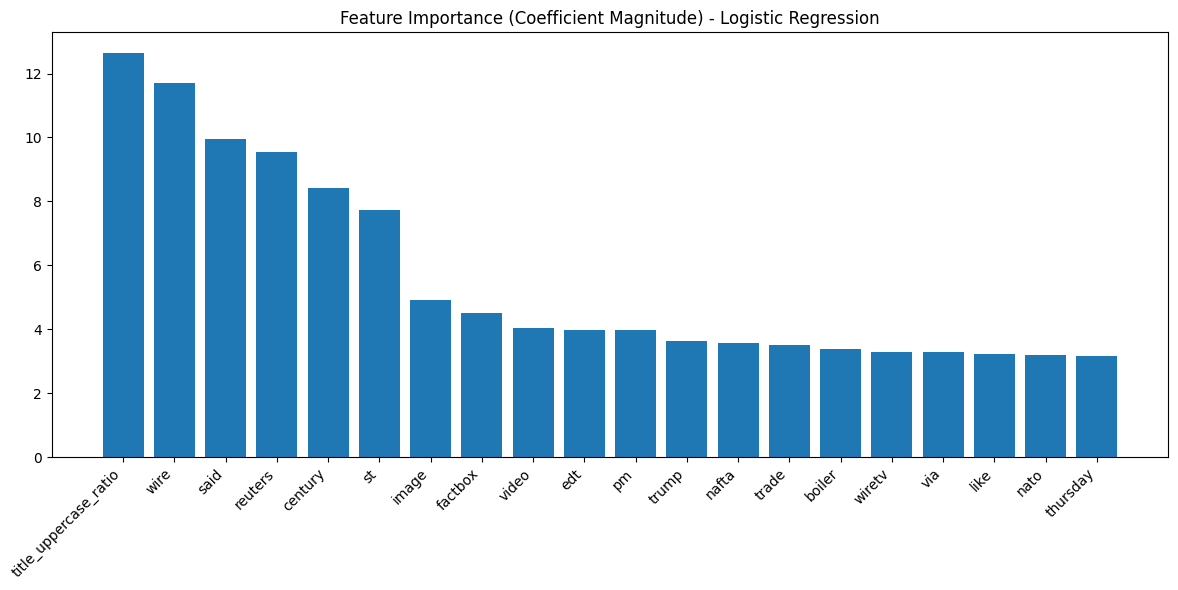


Analyzing feature importance for Naive Bayes...


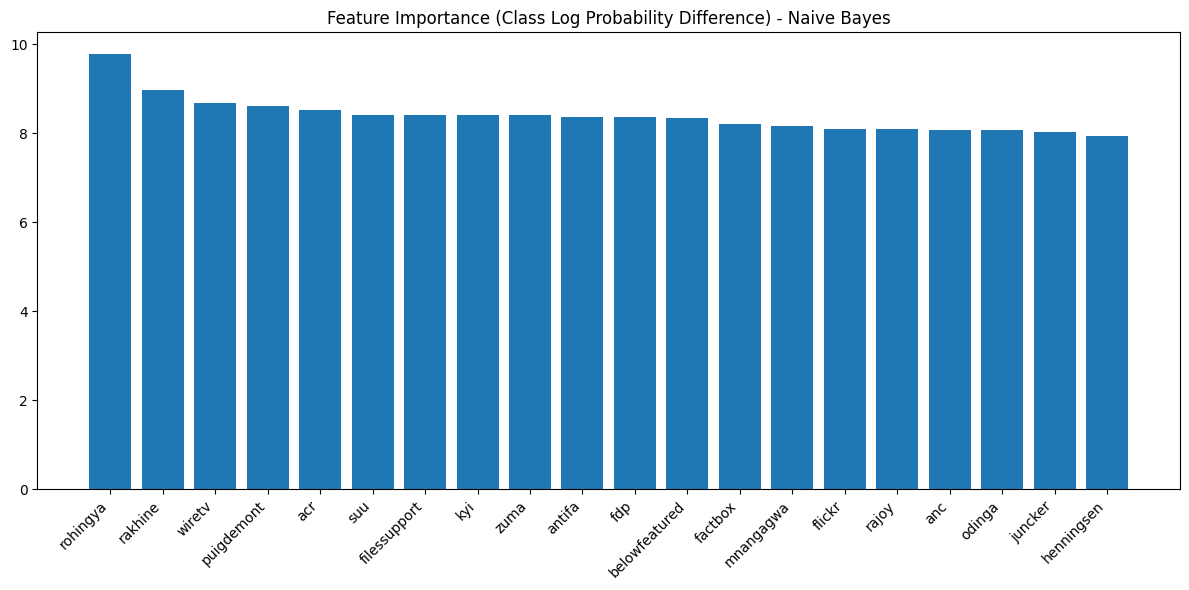


Analyzing feature importance for Random Forest...


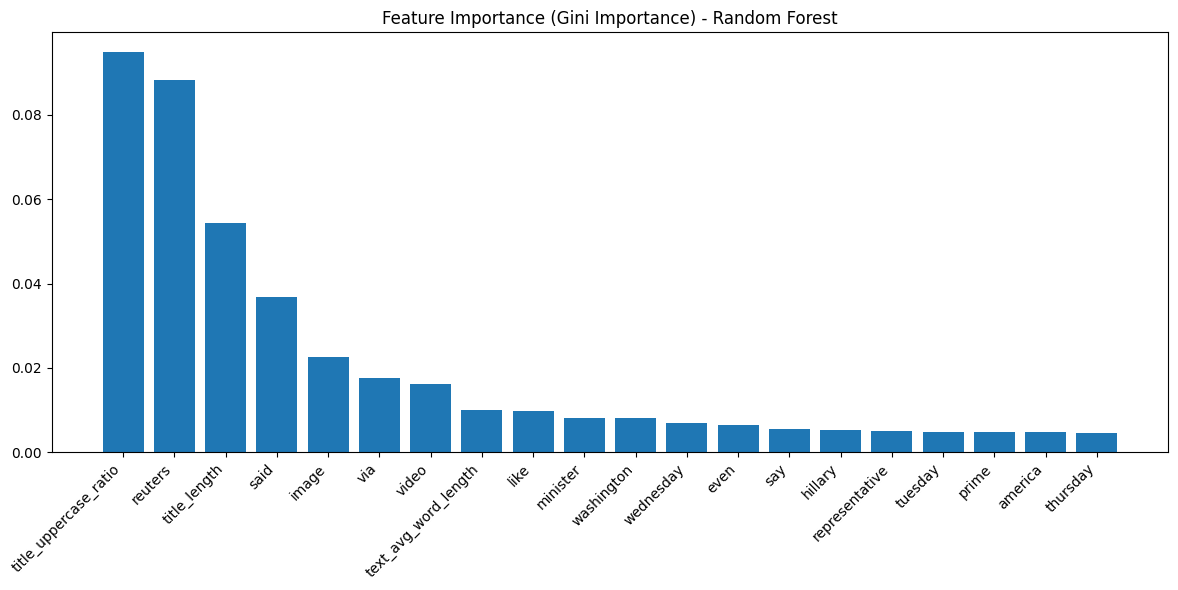

In [14]:
def analyze_feature_importance(model_name, model, feature_names, top_n=20):
    """Analyze and plot feature importance for different model types"""
    plt.figure(figsize=(12, 6))
    
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
        title = f'Feature Importance (Coefficient Magnitude) - {model_name}'
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        title = f'Feature Importance (Gini Importance) - {model_name}'
    else:
        importance = np.abs(model.feature_log_prob_[1] - model.feature_log_prob_[0])
        title = f'Feature Importance (Class Log Probability Difference) - {model_name}'
    
    top_indices = importance.argsort()[-top_n:][::-1]
    plt.bar(range(top_n), importance[top_indices])
    plt.xticks(range(top_n), np.array(feature_names)[top_indices], rotation=45, ha='right')
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

title_vec_tfidf, text_vec_tfidf, _ = tfidf_transformers
title_vec_count, text_vec_count, _ = count_transformers

feature_names = (
    list(title_vec_tfidf.get_feature_names_out()) + 
    list(text_vec_tfidf.get_feature_names_out()) + 
    ['title_length', 'text_length'] +
    list(title_features.columns) +
    list(text_features.columns)
)

print("\nAnalyzing feature importance...")
for name, config in models.items():
    if name != 'BERT':
        print(f"\nAnalyzing feature importance for {name}...")
        try:
            analyze_feature_importance(name, fitted_models[name], feature_names)
        except Exception as e:
            print(f"Error analyzing feature importance for {name}: {str(e)}")

 ## 9. Conclusions and Recommendations



 ### Model Performance Summary:

 1. **Baseline Models**:

    - Simple heuristic baselines provided a good foundation

    - Title length alone achieved reasonable performance

    - Subject-based rules showed strong predictive power



 2. **Traditional ML Models**:

    - Logistic Regression achieved excellent performance

    - Random Forest showed good balance of performance and interpretability

    - Naive Bayes provided fast training with competitive results



 3. **BERT Model**:

    - Achieved the highest accuracy

    - Required significantly more computational resources

    - Better at capturing contextual nuances



 ### Key Findings:

 1. **Feature Importance**:

    - Title length is a strong predictor

    - Certain keywords consistently indicate fake news

    - Stylometric features provide additional signal



 2. **Error Analysis**:

    - Most models struggle with neutral language

    - Articles with mixed credibility signals cause confusion

    - Length-based features can sometimes mislead



 ### Recommendations:

 1. **Model Selection**:

    - For quick deployment: Use Logistic Regression

    - For best accuracy: Use BERT

    - For interpretability: Use Random Forest



 2. **Feature Engineering**:

    - Add more stylometric features

    - Consider source credibility metrics

    - Implement sentiment analysis



 3. **Future Improvements**:

    - Collect more diverse training data

    - Implement ensemble methods

    - Add temporal validation

    - Consider source reliability metrics